In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data.csv')

In [3]:
X = df.drop('overall_rating', axis=1)
y = df['overall_rating']

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, mae, r2

def print_metrics(mse, mae, r2):
    print(f'MSE: {mse:.3f}')
    print(f'MAE: {mae:.3f}')
    print(f'R2: {r2:.3f}')

In [6]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold

def cv_evaluate(model, X, y):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    scoring = {
        'r2': make_scorer(r2_score),
        'mae': make_scorer(mean_absolute_error),
        'mse': make_scorer(mean_squared_error)
    }
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False)

    for key in cv_results.keys():
        if key in ['fit_time', 'score_time']:
            continue
        print(f"{key}: {cv_results[key]}")
        print(f"{key} trung bình: {cv_results[key].mean():.3f} ± {cv_results[key].std():.3f}")
        print()

# Train decision tree with default parameters

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder

model = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('dt', DecisionTreeRegressor(random_state=42))
])
model.fit(X_train, y_train)

Pipeline(steps=[('te', TargetEncoder(cols=['nationality'])),
                ('dt', DecisionTreeRegressor(random_state=42))])

In [8]:
print('Training Set:')
print_metrics(*evaluate_model(model, X_train, y_train))

print('\nValidation Set:')
print_metrics(*evaluate_model(model, X_val, y_val))

Training Set:
MSE: 0.000
MAE: 0.000
R2: 1.000

Validation Set:
MSE: 9.091
MAE: 2.118
R2: 0.806


In [9]:
default_model = model

In [10]:
max_depths = np.arange(1, 21)
mse_train_values, mse_val_values = [], []
mae_train_values, mae_val_values = [], []
r2_train_values, r2_val_values = [], []

for depth in max_depths:
    model = Pipeline([
        ('te', TargetEncoder(cols=['nationality'])),
        ('dt', DecisionTreeRegressor(max_depth=depth))
    ])
    model.fit(X_train, y_train)
    
    mse_train, mae_train, r2_train = evaluate_model(model, X_train, y_train)
    mse_val, mae_val, r2_val = evaluate_model(model, X_val, y_val)

    mse_train_values.append(mse_train)
    mse_val_values.append(mse_val)

    mae_train_values.append(mae_train)
    mae_val_values.append(mae_val)
    
    r2_train_values.append(r2_train)
    r2_val_values.append(r2_val)

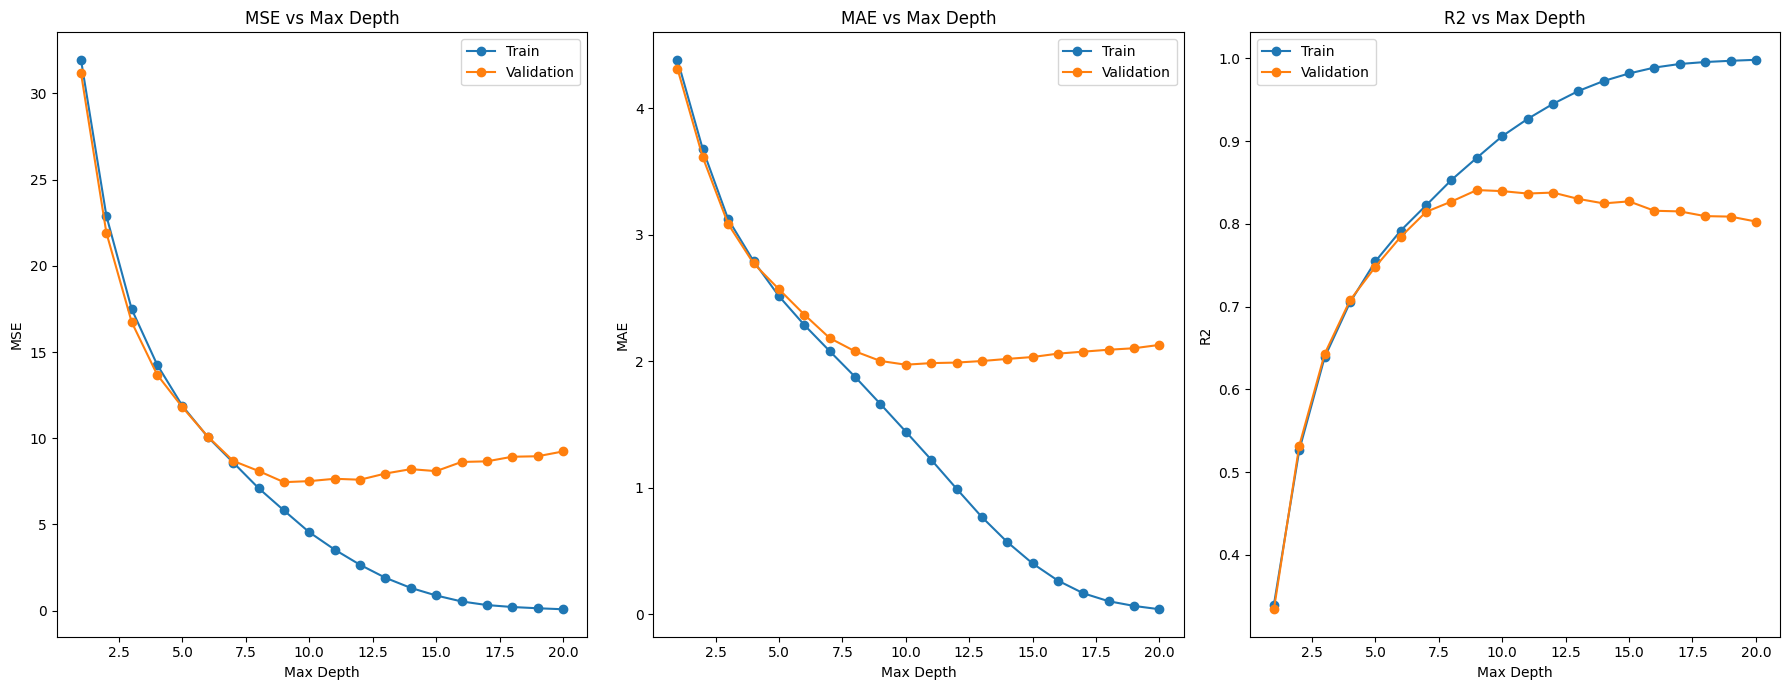

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 7))

plt.subplot(1, 3, 1)
plt.plot(max_depths, mse_train_values, label='Train', marker='o')
plt.plot(max_depths, mse_val_values, label='Validation', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('MSE')
plt.legend()
plt.title('MSE vs Max Depth')

plt.subplot(1, 3, 2)
plt.plot(max_depths, mae_train_values, label='Train', marker='o')
plt.plot(max_depths, mae_val_values, label='Validation', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE vs Max Depth')

plt.subplot(1, 3, 3)
plt.plot(max_depths, r2_train_values, label='Train', marker='o')
plt.plot(max_depths, r2_val_values, label='Validation', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('R2')
plt.legend()
plt.title('R2 vs Max Depth')

plt.tight_layout()
plt.show()

As we can see here, the decision tree is completely fitted to our training data, leading to a "perfect" result. However, it does not perform well on the validation and test sets, which is a sign of **overfitting**. 

# Pruning decision tree having max_depth = 13

In [13]:
from category_encoders import TargetEncoder

encoder = TargetEncoder(cols=['nationality'])
encoder.fit(X_train, y_train)

X_train = encoder.transform(X_train)
X_val = encoder.transform(X_val)

In [15]:
model = DecisionTreeRegressor(random_state=42, max_depth=13)

path = model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas[:-1], path.impurities[:-1]

ccp_alphas.shape, impurities.shape

((2682,), (2682,))

In [16]:
ccp_alphas

array([0.00000000e+00, 3.98025792e-05, 3.98025792e-05, ...,
       2.25424153e+00, 2.50409752e+00, 6.79444114e+00])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [18]:
from sklearn.model_selection import cross_val_score

trees = []
scores = []

cv = KFold(n_splits=5, shuffle=True, random_state=42)

for ccp_alpha in ccp_alphas:
    tree = Pipeline([
        ('te', TargetEncoder(cols=['nationality'])),
        ('dt', DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha))
    ])
    tree.fit(X_train, y_train)
    trees.append(tree)

    score = cross_val_score(tree, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    scores.append(np.mean(score))

MSE_train = [mean_squared_error(y_train, tree.predict(X_train)) for tree in trees]
MSE_test = [mean_squared_error(y_test, tree.predict(X_test)) for tree in trees]

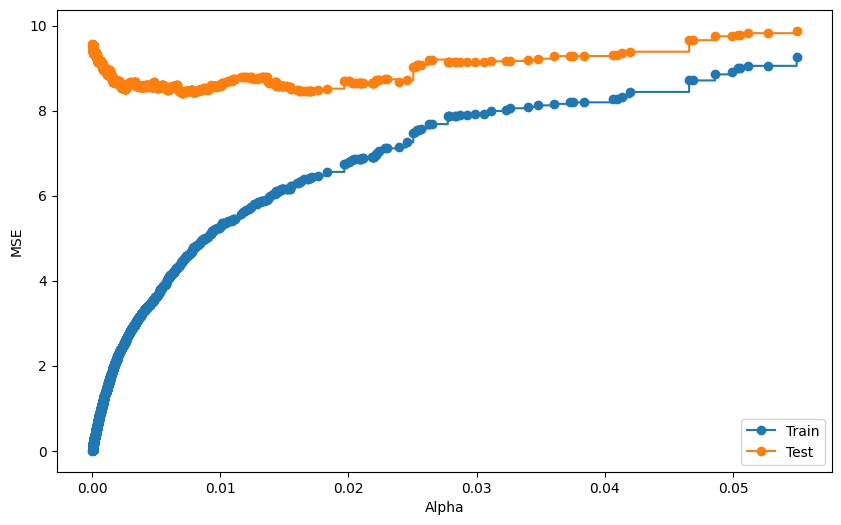

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('Alpha')
ax.set_ylabel('MSE')
    
ax.plot(ccp_alphas[:2630], MSE_train[:2630], marker='o', label='Train', drawstyle='steps-post')
ax.plot(ccp_alphas[:2630], MSE_test[:2630], marker='o', label='Test', drawstyle='steps-post')

ax.legend()
plt.show()

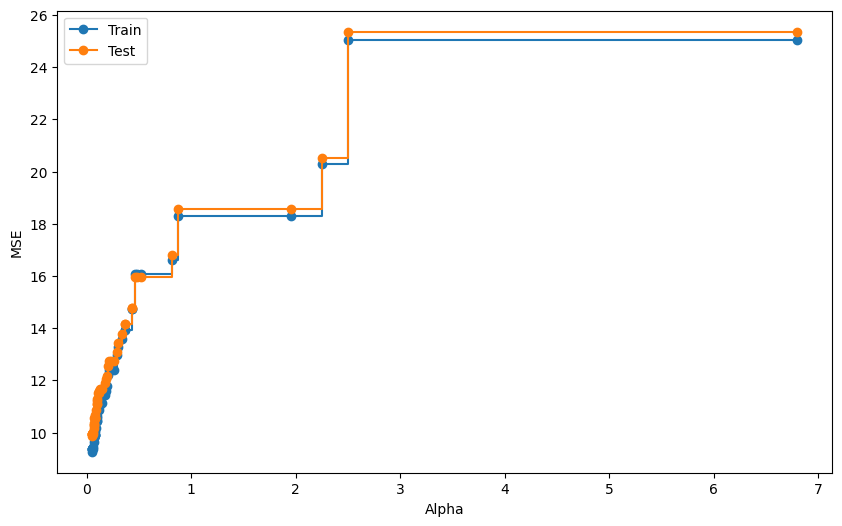

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('Alpha')
ax.set_ylabel('MSE')
    
ax.plot(ccp_alphas[2630:], MSE_train[2630:], marker='o', label='Train', drawstyle='steps-post')
ax.plot(ccp_alphas[2630:], MSE_test[2630:], marker='o', label='Test', drawstyle='steps-post')

ax.legend()
plt.show()

Best alpha: 0.017026192212512392
Best MSE: 8.803252492029696


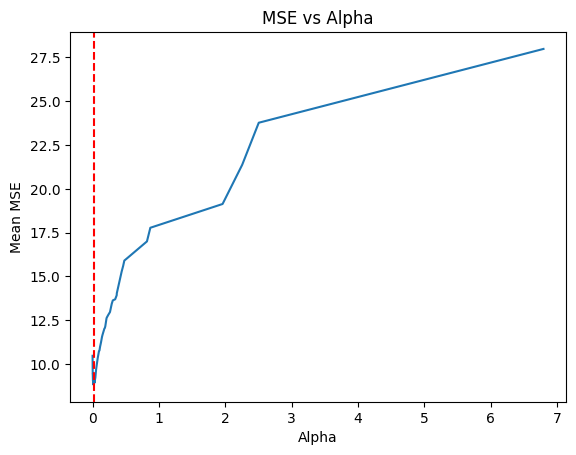

In [25]:
scores = [-score for score in scores]

plt.plot(ccp_alphas[:], scores[:])
plt.xlabel('Alpha')
plt.ylabel('Mean MSE')
plt.title('MSE vs Alpha')

best_idx = np.argmin(scores)
plt.axvline(x=ccp_alphas[best_idx], color='r', linestyle='--', label=f'Best Alpha: {ccp_alphas[best_idx]:.4f}')

print(f"Best alpha: {ccp_alphas[best_idx]}")
print(f"Best MSE: {scores[best_idx]}")

In [27]:
pruning_model = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('dt', DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alphas[best_idx], max_depth=13))
])
pruning_model.fit(X_train, y_train)

Pipeline(steps=[('te', TargetEncoder(cols=['nationality'])),
                ('dt',
                 DecisionTreeRegressor(ccp_alpha=np.float64(0.017026192212512392),
                                       max_depth=13, random_state=42))])

In [28]:
print('Training Set:')
print_metrics(*evaluate_model(pruning_model, X_train, y_train))

print('\nValidation Set:')
print_metrics(*evaluate_model(pruning_model, X_val, y_val))

Training Set:
MSE: 6.486
MAE: 1.913
R2: 0.865

Validation Set:
MSE: 9.289
MAE: 2.199
R2: 0.802


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

pruning_model = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('dt', DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alphas[best_idx], max_depth=13))
])
pruning_model.fit(X_train, y_train)

Pipeline(steps=[('te', TargetEncoder(cols=['nationality'])),
                ('dt',
                 DecisionTreeRegressor(ccp_alpha=np.float64(0.017026192212512392),
                                       max_depth=13, random_state=42))])

In [31]:
print('Training Set:')
print_metrics(*evaluate_model(pruning_model, X_train, y_train))

print('\nTest Set:')
print_metrics(*evaluate_model(pruning_model, X_test, y_test))

Training Set:
MSE: 6.486
MAE: 1.913
R2: 0.865

Test Set:
MSE: 8.527
MAE: 2.126
R2: 0.826


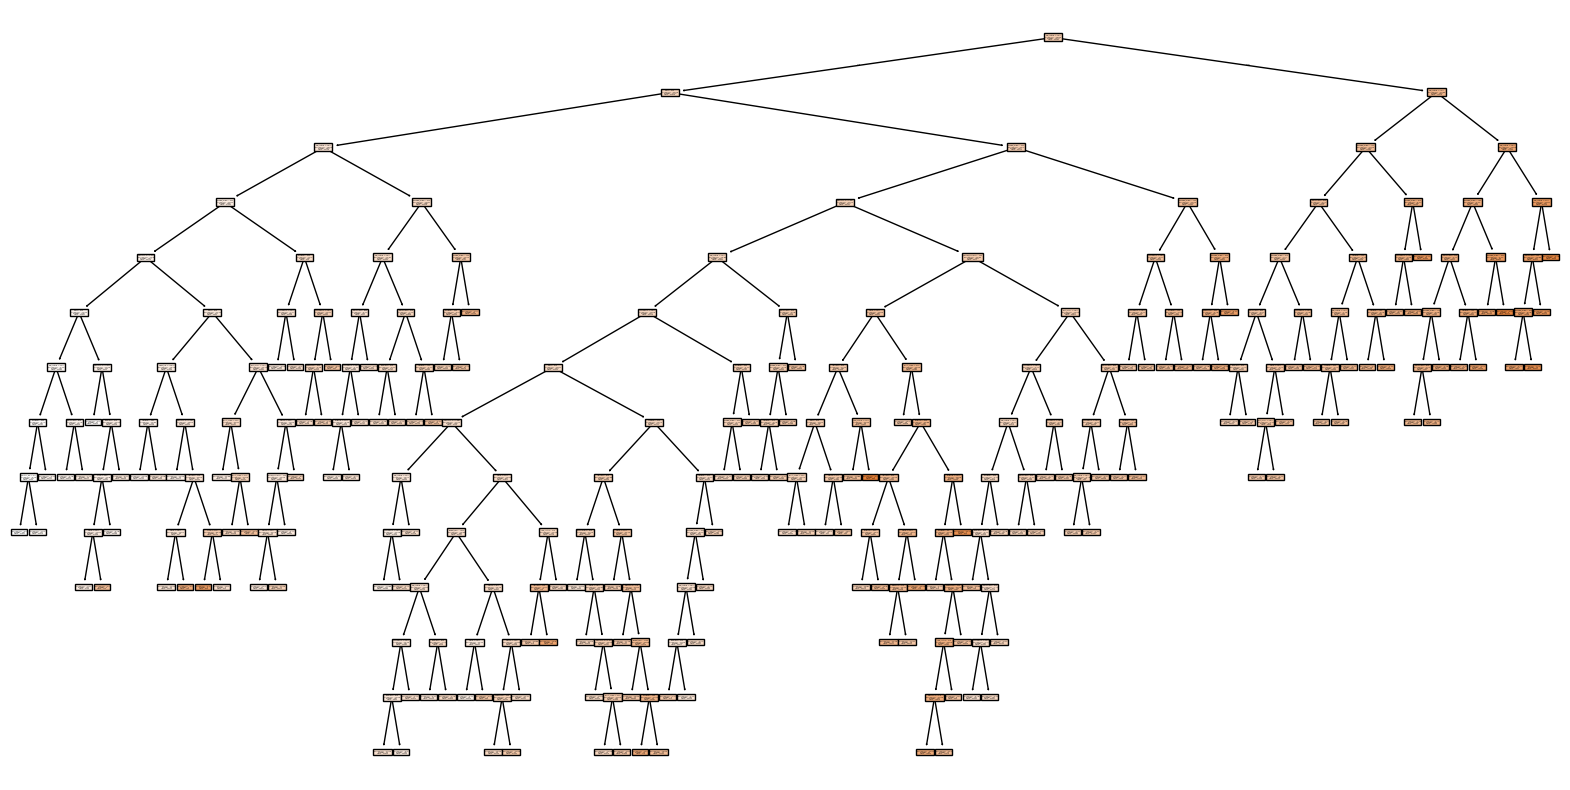

In [32]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(pruning_model.named_steps['dt'], filled=True, feature_names=X.columns)
plt.show()

In [33]:
cv_evaluate(pruning_model, X, y)

test_r2: [0.83208682 0.82984781 0.83379559 0.81233735 0.81196625]
test_r2 trung bình: 0.824 ± 0.010

test_mae: [2.10723397 2.07159451 2.07078634 2.13375509 2.18075253]
test_mae trung bình: 2.113 ± 0.041

test_mse: [8.16488522 8.18305805 8.04599781 8.86350706 9.2324072 ]
test_mse trung bình: 8.498 ± 0.466



# GA to find optimal decision tree

In [52]:
import pandas as pd

df = pd.read_csv('data.csv')

X = df.drop('overall_rating', axis=1)
y = df['overall_rating']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [53]:
from sklearn.model_selection import cross_val_score, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [54]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [37]:
def create_individual():
    max_depth = np.random.randint(1, 25)
    min_samples_split = np.random.randint(2, 50)
    ccp_alpha = np.random.uniform(0, 0.01)
    while True:
        min_samples_leaf = np.random.randint(1, 25)
        if min_samples_leaf * 2 <= min_samples_split:
            break
    return [max_depth, min_samples_split, ccp_alpha, min_samples_leaf]

def fitness(individual):
    max_depth, min_samples_split, ccp_alpha, min_samples_leaf = individual
    
    model = Pipeline([
        ('te', TargetEncoder(cols=['nationality'])),
        ('dt', DecisionTreeRegressor(
            random_state=42, 
            max_depth=max_depth, 
            min_samples_split=min_samples_split,
            ccp_alpha=ccp_alpha,
            min_samples_leaf=min_samples_leaf
        ))
    ])
    
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    return -scores.mean(),

def create_population(pop_size):
    return [create_individual() for _ in range(pop_size)]

def crossover(ind1, ind2, crossover_rate=0.9):
    child1, child2 = ind1[:], ind2[:]
    if np.random.rand() < crossover_rate:
        crossover_point = np.random.randint(1, len(ind1))
        child1 = ind1[:crossover_point] + ind2[crossover_point:]
        child2 = ind2[:crossover_point] + ind1[crossover_point:]
        # for i in range(len(ind1)):
        #     if np.random.rand() < 0.5:
        #         child1[i], child2[i] = child2[i], child1[i]
    def check(child):
        min_samples_split = child[1]
        min_samples_leaf = child[3]
        if min_samples_leaf * 2 > min_samples_split:
            child[3] = min_samples_split // 2
        return child
    child1 = check(child1)
    child2 = check(child2)
    return child1, child2

def mutate(individual, mutation_rate=0.05):
    # if np.random.rand() < mutation_rate:
    #     mutation_point = np.random.randint(0, len(individual))
    #     if mutation_point == 0:
    #         individual[mutation_point] = np.random.randint(1, 30)
    #     elif mutation_point == 1:
    #         individual[mutation_point] = np.random.randint(2, 100)
    #     elif mutation_point == 2:
    #         individual[mutation_point] = np.random.uniform(0, 0.1)
    #     else:
    #         while True:
    #             individual[mutation_point] = np.random.randint(1, 50)
    #             if individual[mutation_point] * 2 <= individual[1]:
    #                 break
    # return individual
    mutated = individual[:]
    for i in range(len(mutated)):
        if np.random.rand() < mutation_rate:
            if i != 3:
                mutated[i] = create_individual()[i]
            else:
                while True:
                    mutated[i] = np.random.randint(1, 50)
                    if mutated[i] * 2 <= mutated[1]:
                        break
    return mutated

In [38]:
def genetic_algorithm(pop_size, generations, generations_values, fitness_values):
    population = create_population(pop_size)

    for generation in range(generations):
        scores = [fitness(ind) for ind in population]
        sorted_scores = sorted(scores, key=lambda x: x[0])
        sorted_population = [ind for ind, score in sorted(zip(population, scores), key=lambda x: x[1])]

        print(f'\nGeneration {generation + 1}: Best MSE: {sorted_scores[0][0]:.3f}')
        print(f'Solution: {sorted_population[0]}')

        generations_values.append(generation + 1)
        fitness_values.append(sorted_scores[0][0])

        # Elitism
        parents = sorted_population[:5]
        # print('Parents:\n', parents)

        next_generation = parents[:]

        while len(next_generation) < pop_size:
            # Selection
            idx1 = np.random.randint(0, len(parents))
            while True:
                idx2 = np.random.randint(0, len(parents))
                if idx2 != idx1:
                    break
            parent1, parent2 = parents[idx1], parents[idx2]

            # Crossover
            child1, child2 = crossover(parent1, parent2)

            # Mutation
            child1 = mutate(child1)
            child2 = mutate(child2)

            next_generation.append(child1)
            next_generation.append(child2)

        population = next_generation
    
    scores = [fitness(ind) for ind in population]
    sorted_scores = sorted(scores, key=lambda x: x[0])
    # print(sorted_scores)
    sorted_population = [ind for ind, score in sorted(zip(population, scores), key=lambda x: x[1])]
    return sorted_population[0]

In [39]:
pop_size = 50
generations = 50

generation_values = []
fitness_values = []

best_individual = genetic_algorithm(pop_size, generations, generation_values, fitness_values)
best_individual


Generation 1: Best MSE: 7.698
Solution: [17, 41, 0.0005340595066624954, 17]

Generation 2: Best MSE: 7.616
Solution: [14, 37, 0.0004993187520904441, 13]

Generation 3: Best MSE: 7.616
Solution: [14, 37, 0.0004993187520904441, 13]

Generation 4: Best MSE: 7.616
Solution: [14, 37, 0.0004993187520904441, 13]

Generation 5: Best MSE: 7.616
Solution: [14, 37, 0.00018937490214237406, 13]

Generation 6: Best MSE: 7.616
Solution: [14, 37, 0.00018937490214237406, 13]

Generation 7: Best MSE: 7.616
Solution: [14, 37, 0.00018937490214237406, 13]

Generation 8: Best MSE: 7.616
Solution: [14, 37, 0.00018937490214237406, 13]

Generation 9: Best MSE: 7.616
Solution: [14, 37, 0.00018937490214237406, 13]

Generation 10: Best MSE: 7.616
Solution: [14, 37, 0.00018937490214237406, 13]

Generation 11: Best MSE: 7.616
Solution: [14, 37, 0.00018937490214237406, 13]

Generation 12: Best MSE: 7.593
Solution: [14, 37, 0.00018937490214237406, 12]

Generation 13: Best MSE: 7.593
Solution: [14, 37, 0.000189374902

[14, 36, 0.00018937490214237406, 12]

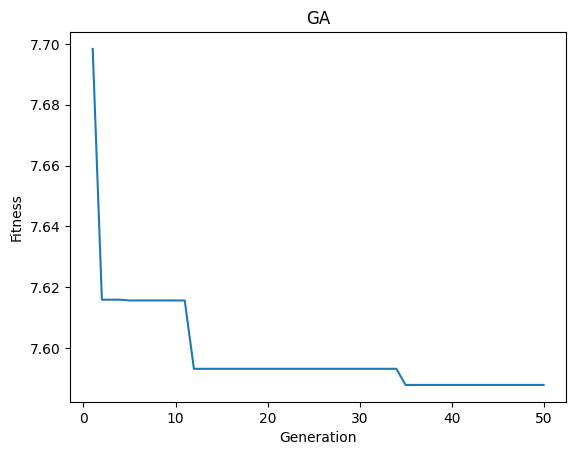

In [40]:
import matplotlib.pyplot as plt

plt.plot(generation_values, fitness_values)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('GA')
plt.show()

In [41]:
best_individual

[14, 36, 0.00018937490214237406, 12]

In [42]:
ga_dt = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('dt', DecisionTreeRegressor(
        random_state=42, 
        max_depth=best_individual[0], 
        min_samples_split=best_individual[1],
        ccp_alpha=best_individual[2],
        min_samples_leaf=best_individual[3]
    ))
])
ga_dt.fit(X_train, y_train)

Pipeline(steps=[('te', TargetEncoder(cols=['nationality'])),
                ('dt',
                 DecisionTreeRegressor(ccp_alpha=0.00018937490214237406,
                                       max_depth=14, min_samples_leaf=12,
                                       min_samples_split=36,
                                       random_state=42))])

In [43]:
print('Training Set:')
print_metrics(*evaluate_model(ga_dt, X_train, y_train))

print('\nTest Set:')
print_metrics(*evaluate_model(ga_dt, X_test, y_test))

Training Set:
MSE: 4.288
MAE: 1.452
R2: 0.911

Test Set:
MSE: 7.488
MAE: 1.934
R2: 0.847


In [44]:
cv_evaluate(ga_dt, X, y)

test_r2: [0.85156277 0.85113259 0.85121949 0.83830538 0.84044673]
test_r2 trung bình: 0.847 ± 0.006

test_mae: [1.90349809 1.91059822 1.92099002 1.91689092 1.94698117]
test_mae trung bình: 1.920 ± 0.015

test_mse: [7.21785489 7.15941824 7.20250219 7.63700942 7.83402321]
test_mse trung bình: 7.410 ± 0.274



In [46]:
ga_tree = ga_dt.named_steps['dt']

import joblib

joblib.dump(ga_tree, 'ga_tree.pkl')
print('Model saved to ga_tree.pkl')

Model saved to ga_tree.pkl


In [47]:
from sklearn.tree import export_text

tree_rules = export_text(ga_tree, feature_names=X.columns.tolist())
print(tree_rules)

|--- ball_control <= 68.50
|   |--- age <= 22.50
|   |   |--- ball_control <= 58.50
|   |   |   |--- standing_tackle <= 60.50
|   |   |   |   |--- nationality <= 65.54
|   |   |   |   |   |--- age <= 20.50
|   |   |   |   |   |   |--- ball_control <= 52.50
|   |   |   |   |   |   |   |--- marking <= 50.50
|   |   |   |   |   |   |   |   |--- positions_GK <= 0.50
|   |   |   |   |   |   |   |   |   |--- heading_accuracy <= 54.50
|   |   |   |   |   |   |   |   |   |   |--- acceleration <= 71.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |   |   |   |--- acceleration >  71.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |--- heading_accuracy >  54.50
|   |   |   |   |   |   |   |   |   |   |--- sprint_speed <= 58.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [53.06]
|   |   |   |   |   |   |   |   |   |   |--- sprint_speed >  58.50
|   |   |   |  

# Grid Search

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

param_grid = {
    'dt__max_depth': [12, 14, 16],
    'dt__min_samples_split': [2, 4, 6],
    'dt__ccp_alpha': [0.0005, 0.001],
    'dt__min_samples_leaf': [8, 16, 24, 32]
}

model = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('dt', DecisionTreeRegressor(random_state=42))
])

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    model, 
    param_grid=param_grid, 
    cv=cv, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('te',
                                        TargetEncoder(cols=['nationality'])),
                                       ('dt',
                                        DecisionTreeRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'dt__ccp_alpha': [0.0005, 0.001],
                         'dt__max_depth': [12, 14, 16],
                         'dt__min_samples_leaf': [8, 16, 24, 32],
                         'dt__min_samples_split': [2, 4, 6]},
             scoring='neg_mean_squared_error')

In [49]:
best_params = grid_search.best_params_
grid_search_model = grid_search.best_estimator_

print(grid_search_model)

Pipeline(steps=[('te', TargetEncoder(cols=['nationality'])),
                ('dt',
                 DecisionTreeRegressor(ccp_alpha=0.0005, max_depth=16,
                                       min_samples_leaf=24, random_state=42))])


In [51]:
print('Training Set:')
print_metrics(*evaluate_model(grid_search_model, X_train, y_train))

print('\nTest Set:')
print_metrics(*evaluate_model(grid_search_model, X_test, y_test))

Training Set:
MSE: 5.067
MAE: 1.589
R2: 0.895

Test Set:
MSE: 7.383
MAE: 1.962
R2: 0.849


In [53]:
cv_evaluate(grid_search_model, X, y)

test_r2: [0.85244991 0.85278337 0.84932051 0.84257379 0.8430635 ]
test_r2 trung bình: 0.848 ± 0.004

test_mae: [1.91444806 1.9059282  1.93987973 1.91746375 1.95766462]
test_mae trung bình: 1.927 ± 0.019

test_mse: [7.17471705 7.0800276  7.29443231 7.43540777 7.70554028]
test_mse trung bình: 7.338 ± 0.219



In [54]:
grid_search_dt = grid_search_model.named_steps['dt']

import joblib

joblib.dump(grid_search_dt, 'grid_search_dt.pkl')
print('Model saved to grid_search_dt.pkl')

Model saved to grid_search_dt.pkl


# Randomized Search 

In [55]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'dt__max_depth': np.arange(1, 30),
    'dt__min_samples_split': np.arange(2, 100),
    'dt__ccp_alpha': np.linspace(0, 0.1, 100),
    'dt__min_samples_leaf': np.arange(1, 50)
}

model = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('dt', DecisionTreeRegressor(random_state=42))
])

random_search = RandomizedSearchCV(
    model, 
    param_distributions=param_grid, 
    n_iter=100, 
    cv=cv,
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    random_state=42
)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('te',
                                              TargetEncoder(cols=['nationality'])),
                                             ('dt',
                                              DecisionTreeRegressor(random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'dt__ccp_alpha': array([0.        , 0.0010101 , 0.0020202 , 0.0030303 , 0.0040404 ,
       0.00505051, 0.00606061, 0.00707071, 0.00808081, 0.00909091,
       0...
                                        'dt__min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   random_state=42, scoring='neg_mean_squared_error')

In [56]:
random_search.best_params_

{'dt__min_samples_split': np.int64(40),
 'dt__min_samples_leaf': np.int64(10),
 'dt__max_depth': np.int64(15),
 'dt__ccp_alpha': np.float64(0.0)}

In [57]:
random_search_model = random_search.best_estimator_

print('Training Set:')
print_metrics(*evaluate_model(random_search_model, X_train, y_train))

print('\nTest Set:')
print_metrics(*evaluate_model(random_search_model, X_test, y_test))

Training Set:
MSE: 4.301
MAE: 1.449
R2: 0.911

Test Set:
MSE: 7.349
MAE: 1.927
R2: 0.850


In [58]:
cv_evaluate(random_search_model, X, y)

test_r2: [0.85058732 0.85291439 0.85003303 0.83617305 0.83703239]
test_r2 trung bình: 0.845 ± 0.007

test_mae: [1.90460432 1.900742   1.92886802 1.93974476 1.98877219]
test_mae trung bình: 1.933 ± 0.032

test_mse: [7.26528663 7.07372683 7.25993931 7.73772186 8.00166629]
test_mse trung bình: 7.468 ± 0.346



In [59]:
random_search_dt = random_search_model.named_steps['dt']

import joblib

joblib.dump(random_search_dt, 'random_search_dt.pkl')
print('Model saved to random_search_dt.pkl')

Model saved to random_search_dt.pkl


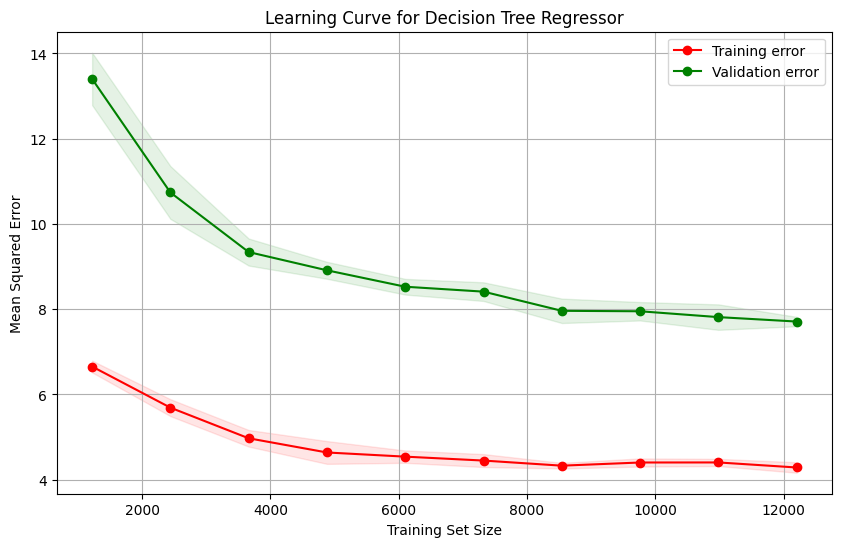

In [61]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    random_search_model,
    X_train,
    y_train,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve for Decision Tree Regressor")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Squared Error")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training error")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation error")

plt.legend(loc="best")
plt.grid()
plt.show()

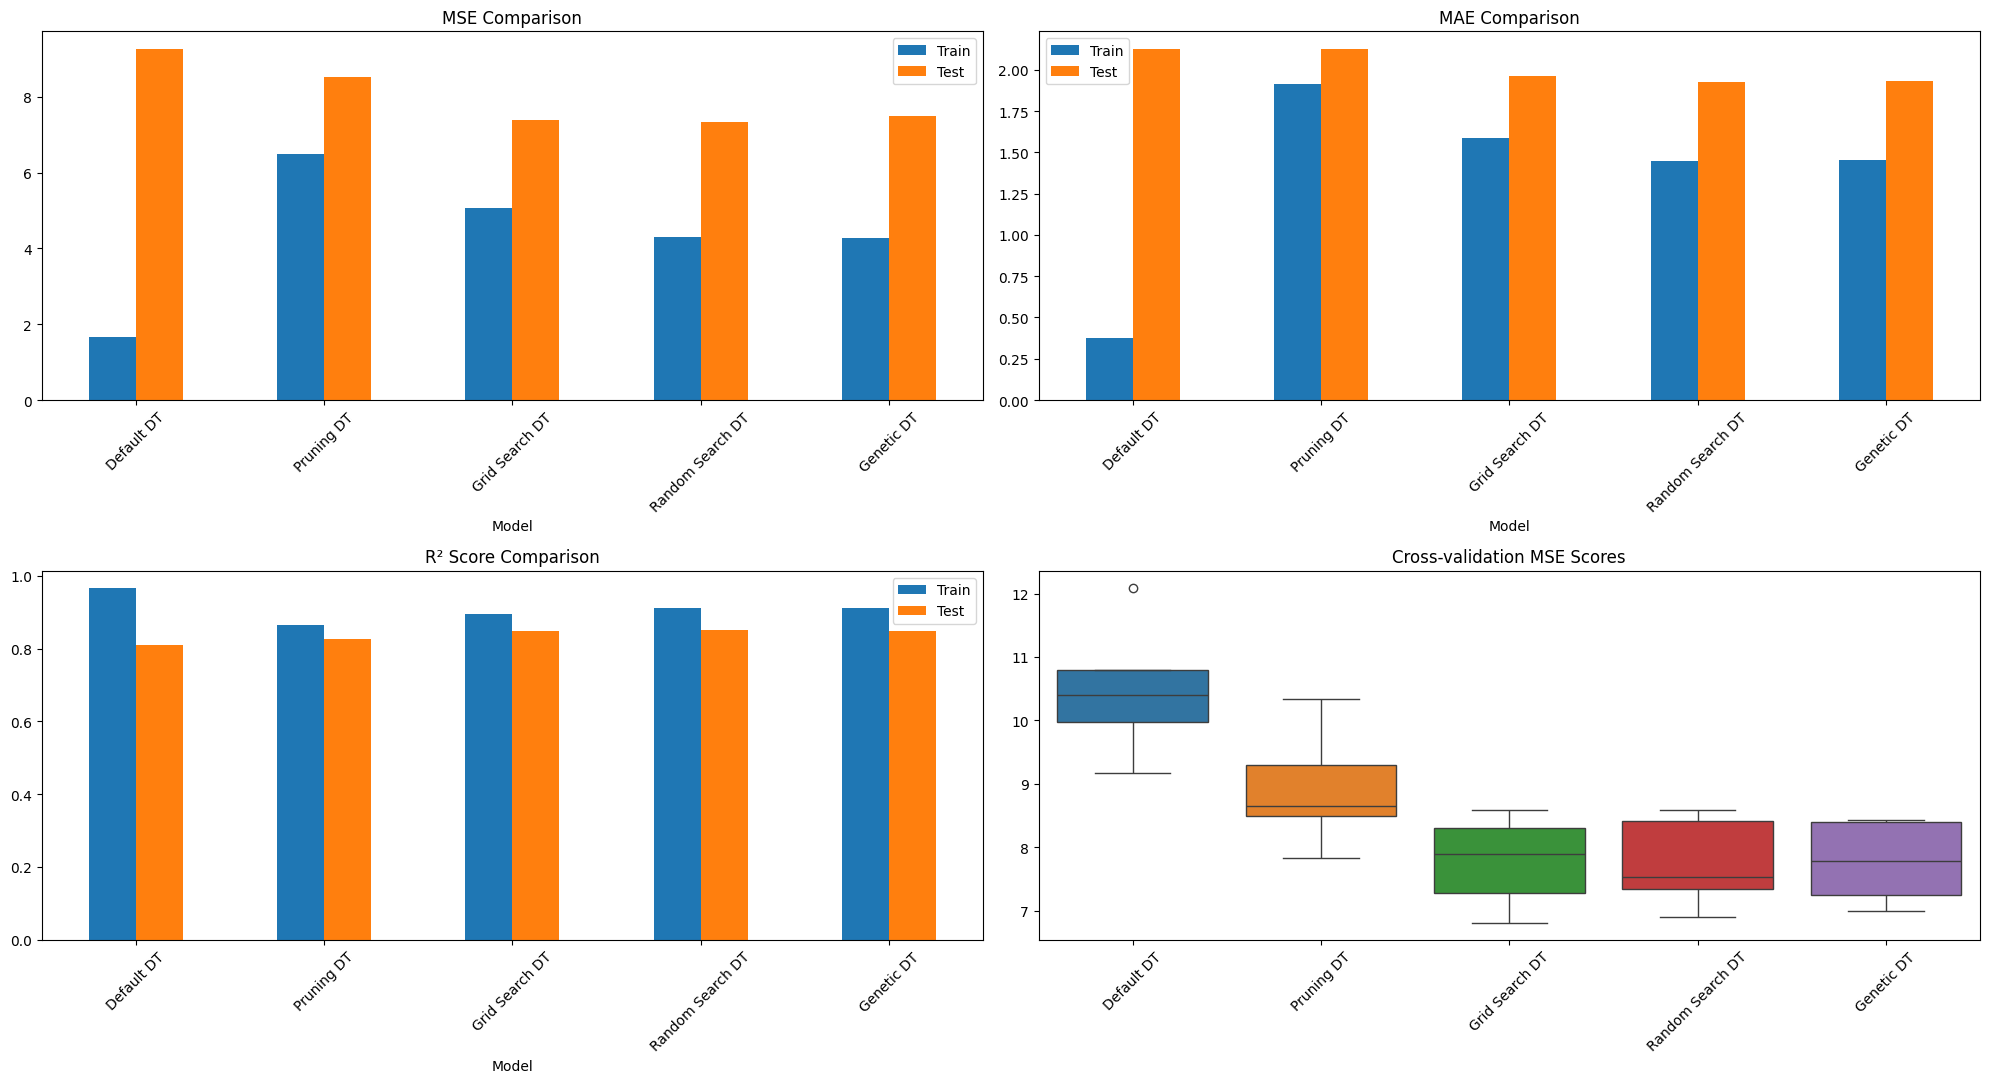


Detailed Performance Metrics:
----------------------------
                  Train MSE  Test MSE  Train MAE  Test MAE  Train R2  Test R2
Model                                                                        
Default DT           1.6723    9.2688     0.3769    2.1266    0.9653   0.8107
Pruning DT           6.4862    8.5268     1.9129    2.1265    0.8654   0.8259
Grid Search DT       5.0667    7.3831     1.5893    1.9618    0.8948   0.8492
Random Search DT     4.3012    7.3490     1.4490    1.9268    0.9107   0.8499
Genetic DT           4.2876    7.4880     1.4518    1.9338    0.9110   0.8471


In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, KFold

def compare_multiple_models(models_dict, X_train, X_test, y_train, y_test, cv=5):
    # Collect predictions and metrics
    predictions = {}
    metrics = {
        'Model': [],
        'Train MSE': [],
        'Test MSE': [],
        'Train MAE': [],
        'Test MAE': [],
        'Train R2': [],
        'Test R2': []
    }
    
    cv_scores = {}
    residuals = {}
    
    for name, model in models_dict.items():
        # Get predictions
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        predictions[name] = {'train': train_pred, 'test': test_pred}
        
        # Calculate metrics
        metrics['Model'].append(name)
        metrics['Train MSE'].append(mean_squared_error(y_train, train_pred))
        metrics['Test MSE'].append(mean_squared_error(y_test, test_pred))
        metrics['Train MAE'].append(mean_absolute_error(y_train, train_pred))
        metrics['Test MAE'].append(mean_absolute_error(y_test, test_pred))
        metrics['Train R2'].append(r2_score(y_train, train_pred))
        metrics['Test R2'].append(r2_score(y_test, test_pred))
        
        # Cross-validation scores
        cv_scores[name] = -cross_val_score(model, X_train, y_train, 
                                         cv=cv, scoring='neg_mean_squared_error')
    
    # 2. Create metrics DataFrame
    metrics_df = pd.DataFrame(metrics).set_index('Model')
    
    # 3. Visualizations
    # plt.style.use('seaborn')
    
    # 3.1 Performance Metrics Comparison
    fig = plt.figure(figsize=(20, 15))
    
    # MSE Comparison
    plt.subplot(321)
    metrics_comparison = pd.DataFrame({
        'Train': metrics_df['Train MSE'],
        'Test': metrics_df['Test MSE']
    }, index=metrics_df.index)
    metrics_comparison.plot(kind='bar', ax=plt.gca())
    plt.title('MSE Comparison')
    plt.xticks(rotation=45)
    
    # MAE Comparison
    plt.subplot(322)
    metrics_comparison = pd.DataFrame({
        'Train': metrics_df['Train MAE'],
        'Test': metrics_df['Test MAE']
    }, index=metrics_df.index)
    metrics_comparison.plot(kind='bar', ax=plt.gca())
    plt.title('MAE Comparison')
    plt.xticks(rotation=45)
    
    # R2 Comparison
    plt.subplot(323)
    metrics_comparison = pd.DataFrame({
        'Train': metrics_df['Train R2'],
        'Test': metrics_df['Test R2']
    }, index=metrics_df.index)
    metrics_comparison.plot(kind='bar', ax=plt.gca())
    plt.title('R² Score Comparison')
    plt.xticks(rotation=45)
    
    # Cross-validation Scores
    plt.subplot(324)
    cv_data = pd.DataFrame(cv_scores)
    sns.boxplot(data=cv_data)
    plt.title('Cross-validation MSE Scores')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed metrics
    print("\nDetailed Performance Metrics:")
    print("----------------------------")
    print(metrics_df.round(4))

models = {
    'Default DT': default_model,
    'Pruning DT': pruning_model,
    'Grid Search DT': grid_search_model,
    'Random Search DT': random_search_model,
    'Genetic DT': ga_dt,
}

compare_multiple_models(
    models_dict=models,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test
)